In [1]:
import json
import numpy as np
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import sys
sys.path.insert(1, '/content/drive/My Drive/Emotion-Detection')

In [3]:
json_file = open('/content/drive/My Drive/Emotion-Detection/lstm_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights('/content/drive/My Drive/Emotion-Detection/lstm_model.h5')

In [4]:
with open('/content/drive/My Drive/Emotion-Detection/dictionary.json', 'r') as dictionary_file:
    dictionary = json.load(dictionary_file)

{'input_dim': 109391, 'input_length': 157, 'num_classes': 7}


In [5]:
infile = open('/content/drive/My Drive/Emotion-Detection/tokenizer.pickle','rb')
tokenizer = pickle.load(infile)
infile.close()

In [6]:
infile = open('/content/drive/My Drive/Emotion-Detection/encoder.pickle','rb')
encoder = pickle.load(infile)
infile.close()

In [7]:
infile = open('/content/drive/My Drive/Emotion-Detection/ml_model.pickle','rb')
clf = pickle.load(infile)
infile.close()

In [8]:
infile = open('/content/drive/My Drive/Emotion-Detection/ml_vector.pickle','rb')
cv = pickle.load(infile)
infile.close()

In [9]:
import re
from contractions import CONTRACTION_MAP
from stopword import STOPWORDS
def remove_special_characters(text):
	text = re.sub('[^a-zA-Z0-9\s]', '', text)
	return text

def rm_repetitions(doc):
    pattern = re.compile(r"(.)\1{2,}", re.DOTALL)
    doc = pattern.sub(r"\1", doc)
    return doc

def rm_stop_words(doc):
    tokens = doc.strip(" ")
    filtered_tokens = [token for token in tokens if token not in STOPWORDS]
    filtered_text = ''.join(filtered_tokens)    
    return filtered_text

def expand_contractions(doc, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match) \
                                   if contraction_mapping.get(match) \
                                    else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, doc)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


def preprocess(doc):
  doc = doc.lower()
  doc = rm_repetitions(doc)
  doc = expand_contractions(doc, contraction_mapping=CONTRACTION_MAP)
  doc = remove_special_characters(doc)
  return doc

In [10]:
lstm = ['Fear', 'Happy', 'Sad']
ml = [ 'Bad', 'Surprise', 'Anger', 'Digust']
def stack(inputX,tokenizer,model,encoder,cv,clf,lstm,ml):
  tokenized = tokenizer.texts_to_sequences([inputX])
  pad_data = pad_sequences(tokenized,157)
  pred = model.predict(pad_data)
  emot = encoder.inverse_transform(pred)[0]
  x_data = cv.transform([inputX])
  label = clf.predict(x_data)[0]
  if(emot in lstm):
    return emot
  elif(label in ml):
    return label
  else:
    return emot

In [11]:
evalSentence = "I am sorry to hear about the passing of #SushantSinghRajput. A young & talented actor, gone too soon. My condolences to his family, friends & fans across the world."
evalSentence = preprocess(evalSentence)

In [12]:
print(stack(evalSentence,tokenizer,model,encoder,cv,clf,lstm,ml))

Sad


In [13]:
import pandas as pd
import numpy as np
import scipy
import sklearn
import nltk

In [17]:
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return fig, ax

def get_metrics(test_labels, predicted_labels):
    
    print('Accuracy:', np.round(
                        metrics.accuracy_score(test_labels, 
                                               predicted_labels),
                        10))
    print('Precision:', np.round(
                        metrics.precision_score(test_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        10))
    print('Recall:', np.round(
                        metrics.recall_score(test_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        10))
    print('F1 Score:', np.round(
                        metrics.f1_score(test_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        10))
                            
def display_classification_report(test_labels, predicted_labels, classes):

    report = metrics.classification_report(y_true=test_labels, y_pred=predicted_labels) 
    print(report)
    
      
def display_model_performance_metrics(classifier,predicted_labels,test_labels, classes):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(test_labels, predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(test_labels, predicted_labels,classes)
    fig, ax = plot_confusion_matrix(test_labels, predicted_labels, classes, normalize=True)
    fig.set_size_inches(18.5, 10.5)

In [18]:
df = pd.read_csv('/content/drive/My Drive/Emotion-Detection/dataset_final_preprocessed.csv')
df = df.dropna()
df.shape

(208043, 2)

In [19]:
data_classes = list(df['Emotion'].unique())
data_classes = np.array(data_classes)
data_classes

array(['Happy', 'Sad', 'Fear', 'Anger', 'Bad', 'Surprise', 'Digust'],
      dtype='<U8')

In [20]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df['Text'].values.astype('U'),df['Emotion'].values.astype('U'), test_size=0.10, random_state=50)
# x_test = x_test[:000]
# y_test = y_test[:1000]

In [ ]:
pred = []
for text in x_test:
  pred.append(stack(str(text),tokenizer,model,encoder,cv,clf,lstm,ml))
pred = np.array(pred).astype('U')

In [ ]:
pred

array(['Fear', 'Happy', 'Sad', ..., 'Fear', 'Fear', 'Surprise'],
      dtype='<U8')

In [ ]:
get_metrics(pred,y_test)

Accuracy: 0.8830088921
Precision: 0.8862166984
Recall: 0.8830088921
F1 Score: 0.8834644786


Normalized confusion matrix


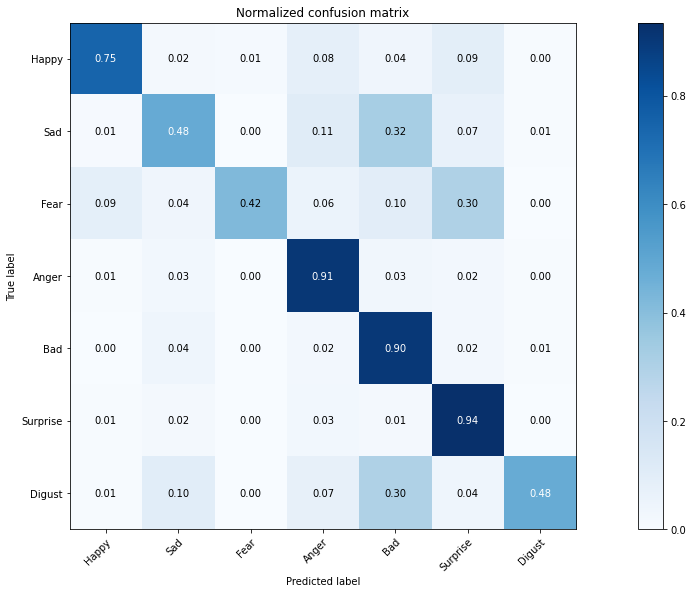

In [ ]:
fig, ax = plot_confusion_matrix(y_test,pred,data_classes, normalize=True)
fig.set_size_inches(18.5, 10.5)
fig.savefig('/content/drive/My Drive/Emotion-Detection/stack_confusion_matrix.png')